In [1]:
import torch # CUDA 12.6 version used
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
# Base Hyperparameters

batch_size = 128
epoch_num = 25
patience = 3
learning_rate = 0.001

In [3]:
# Set Device to GPU if Available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Arrange Training, Validation, and Testing Data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

all_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size = int(0.9 * len(all_training_data))
validation_size = len(all_training_data) - training_size
training_data, validation_data = random_split(all_training_data, [training_size, validation_size])

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# Base Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_t1 = CNN()
model_t1.to(device)
crit_t1 = nn.CrossEntropyLoss()
opt_t1 = optim.Adam(model_t1.parameters(), lr=learning_rate)


Task 1

In [5]:
# Task 1 Model Training and Validation

max_validation_loss = float('inf')
stop_counter = 0
training_loss_values = []
validation_loss_values = []

for epoch in range(epoch_num):
    model_t1.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t1.zero_grad()
        outputs = model_t1(inputs)
        loss = crit_t1(outputs, labels)
        loss.backward()
        opt_t1.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model_t1.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t1(validation_inputs)
            validation_loss += crit_t1(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")
    
    if validation_loss < max_validation_loss:
        max_validation_loss = validation_loss
        torch.save(model_t1.state_dict(), "cnn_model.pth")
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            break

print("done")

Epoch 1: Training Loss = 1.753, Validation Loss = 1.480
Epoch 2: Training Loss = 1.416, Validation Loss = 1.327
Epoch 3: Training Loss = 1.268, Validation Loss = 1.204
Epoch 4: Training Loss = 1.161, Validation Loss = 1.129
Epoch 5: Training Loss = 1.076, Validation Loss = 1.058
Epoch 6: Training Loss = 1.012, Validation Loss = 1.021
Epoch 7: Training Loss = 0.942, Validation Loss = 0.949
Epoch 8: Training Loss = 0.891, Validation Loss = 0.932
Epoch 9: Training Loss = 0.846, Validation Loss = 0.940
Epoch 10: Training Loss = 0.806, Validation Loss = 0.900
Epoch 11: Training Loss = 0.771, Validation Loss = 0.878
Epoch 12: Training Loss = 0.736, Validation Loss = 0.877
Epoch 13: Training Loss = 0.702, Validation Loss = 0.890
Epoch 14: Training Loss = 0.681, Validation Loss = 0.849
Epoch 15: Training Loss = 0.649, Validation Loss = 0.880
Epoch 16: Training Loss = 0.627, Validation Loss = 0.850
Epoch 17: Training Loss = 0.604, Validation Loss = 0.914
done


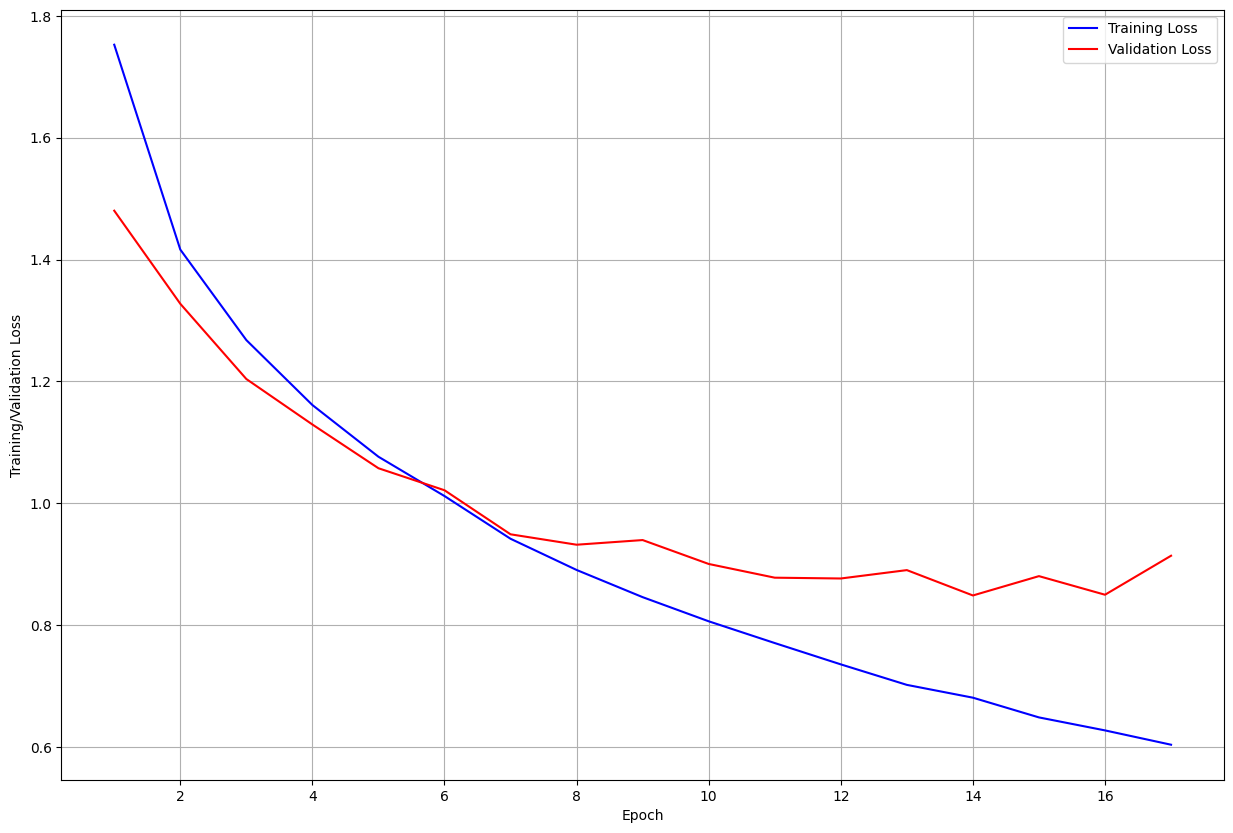

In [6]:
# Task 1 Convergence Graph

x_vals = list(range(1, len(training_loss_values)+1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, training_loss_values, color='b', label='Training Loss')
plt.plot(x_vals, validation_loss_values, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Training/Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

Task 2

In [58]:
# Task 2 New Hyperparameters

L2_penalty = 0.001
dropout = 0.4

In [59]:
# Task 2 Models

class CNNBasic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(func.relu(self.fc1(x)))
        x = self.dropout(func.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model_t2_basic = CNNBasic()
model_t2_basic.to(device)
crit_t2 = nn.CrossEntropyLoss()
opt_t2 = optim.Adam(model_t2_basic.parameters(), lr=learning_rate)

model_t2_reg = CNNBasic()
model_t2_reg.to(device)
opt_t2_reg = optim.Adam(model_t2_reg.parameters(), lr=learning_rate, weight_decay=L2_penalty)

model_t2_dropout = CNNDropout()
model_t2_dropout.to(device)
opt_t2_dropout = optim.Adam(model_t2_dropout.parameters(), lr=learning_rate)

In [60]:
# Task 2 Model Training and Validation - No Regularisation or Dropout

training_loss_values_basic = []
validation_loss_values_basic = []

for epoch in range(epoch_num):
    model_t2_basic.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2.zero_grad()
        outputs = model_t2_basic(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_basic.append(training_loss)
            
    model_t2_basic.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_basic(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_basic.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.736, Validation Loss = 1.506
Epoch 2: Training Loss = 1.392, Validation Loss = 1.297
Epoch 3: Training Loss = 1.239, Validation Loss = 1.181
Epoch 4: Training Loss = 1.140, Validation Loss = 1.100
Epoch 5: Training Loss = 1.051, Validation Loss = 1.018
Epoch 6: Training Loss = 0.985, Validation Loss = 0.991
Epoch 7: Training Loss = 0.923, Validation Loss = 0.945
Epoch 8: Training Loss = 0.874, Validation Loss = 0.912
Epoch 9: Training Loss = 0.834, Validation Loss = 0.917
Epoch 10: Training Loss = 0.789, Validation Loss = 0.912
Epoch 11: Training Loss = 0.759, Validation Loss = 0.861
Epoch 12: Training Loss = 0.724, Validation Loss = 0.844
Epoch 13: Training Loss = 0.699, Validation Loss = 0.868
Epoch 14: Training Loss = 0.669, Validation Loss = 0.867
Epoch 15: Training Loss = 0.637, Validation Loss = 0.834
Epoch 16: Training Loss = 0.621, Validation Loss = 0.812
Epoch 17: Training Loss = 0.599, Validation Loss = 0.835
Epoch 18: Training Loss = 0.571, Validat

In [61]:
# Task 2 Model Training and Validation - L2 Regularisation

training_loss_values_reg = []
validation_loss_values_reg = []

for epoch in range(epoch_num):
    model_t2_reg.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_reg.zero_grad()
        outputs = model_t2_reg(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_reg.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_reg.append(training_loss)
            
    model_t2_reg.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_reg(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_reg.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.774, Validation Loss = 1.523
Epoch 2: Training Loss = 1.461, Validation Loss = 1.357
Epoch 3: Training Loss = 1.306, Validation Loss = 1.226
Epoch 4: Training Loss = 1.185, Validation Loss = 1.124
Epoch 5: Training Loss = 1.097, Validation Loss = 1.080
Epoch 6: Training Loss = 1.023, Validation Loss = 1.039
Epoch 7: Training Loss = 0.960, Validation Loss = 0.953
Epoch 8: Training Loss = 0.907, Validation Loss = 0.932
Epoch 9: Training Loss = 0.862, Validation Loss = 0.896
Epoch 10: Training Loss = 0.823, Validation Loss = 0.924
Epoch 11: Training Loss = 0.784, Validation Loss = 0.867
Epoch 12: Training Loss = 0.755, Validation Loss = 0.827
Epoch 13: Training Loss = 0.728, Validation Loss = 0.823
Epoch 14: Training Loss = 0.698, Validation Loss = 0.804
Epoch 15: Training Loss = 0.681, Validation Loss = 0.797
Epoch 16: Training Loss = 0.661, Validation Loss = 0.881
Epoch 17: Training Loss = 0.636, Validation Loss = 0.804
Epoch 18: Training Loss = 0.616, Validat

In [62]:
# Task 2 Model Training and Validation - Dropout

training_loss_values_dropout = []
validation_loss_values_dropout = []

for epoch in range(epoch_num):
    model_t2_dropout.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_dropout.zero_grad()
        outputs = model_t2_dropout(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_dropout.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_dropout.append(training_loss)
            
    model_t2_dropout.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_dropout(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_dropout.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.860, Validation Loss = 1.533
Epoch 2: Training Loss = 1.527, Validation Loss = 1.331
Epoch 3: Training Loss = 1.379, Validation Loss = 1.211
Epoch 4: Training Loss = 1.278, Validation Loss = 1.162
Epoch 5: Training Loss = 1.207, Validation Loss = 1.087
Epoch 6: Training Loss = 1.135, Validation Loss = 1.033
Epoch 7: Training Loss = 1.079, Validation Loss = 1.015
Epoch 8: Training Loss = 1.035, Validation Loss = 0.969
Epoch 9: Training Loss = 0.986, Validation Loss = 0.919
Epoch 10: Training Loss = 0.957, Validation Loss = 0.932
Epoch 11: Training Loss = 0.929, Validation Loss = 0.921
Epoch 12: Training Loss = 0.903, Validation Loss = 0.881
Epoch 13: Training Loss = 0.872, Validation Loss = 0.918
Epoch 14: Training Loss = 0.847, Validation Loss = 0.850
Epoch 15: Training Loss = 0.826, Validation Loss = 0.889
Epoch 16: Training Loss = 0.806, Validation Loss = 0.847
Epoch 17: Training Loss = 0.782, Validation Loss = 0.841
Epoch 18: Training Loss = 0.777, Validat

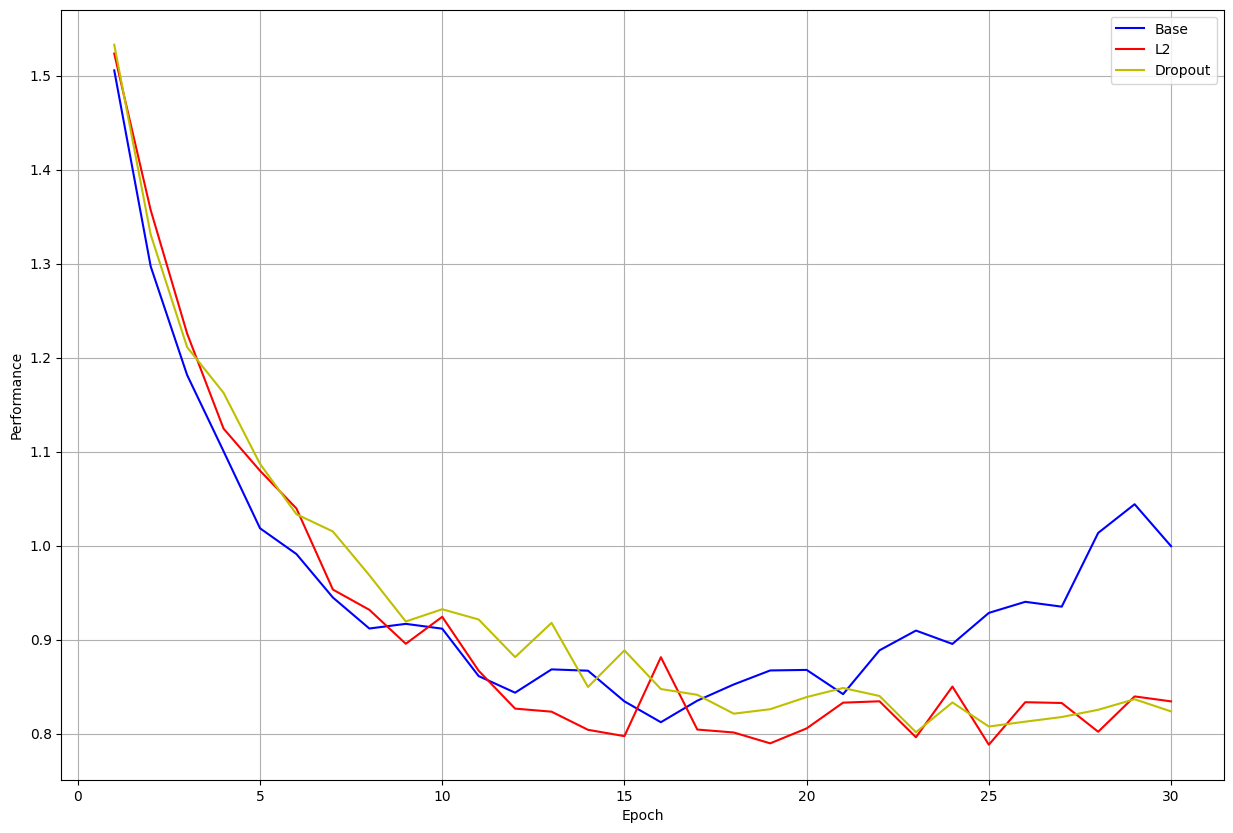

In [63]:
# Task 2 Convergence Graph

x_vals = list(range(1, epoch_num + 1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, validation_loss_values_basic, color='b', label='Base')
plt.plot(x_vals, validation_loss_values_reg, color='r', label='L2')
plt.plot(x_vals, validation_loss_values_dropout, color='y', label='Dropout')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.show()

Task 3

In [74]:
# Task 3 New Hyperparameters

num_features = [32, 32, 64]

In [75]:
# Task 3 Model

class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=num_features[0])
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=num_features[1])
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm_3 = nn.BatchNorm2d(num_features=num_features[2])
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.batch_norm_1(self.conv1(x))))
        x = self.pool(func.relu(self.batch_norm_2(self.conv2(x))))
        x = self.pool(func.relu(self.batch_norm_3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
model_t3 = CNNBatchNorm()
model_t3.to(device)
crit_t3 = nn.CrossEntropyLoss()
opt_t3 = optim.Adam(model_t3.parameters(), lr=learning_rate)

In [76]:
# Task 3 Model Training and Validation

training_loss_values_bn = []
validation_loss_values_bn = []

for epoch in range(epoch_num):
    model_t3.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t3.zero_grad()
        outputs = model_t3(inputs)
        loss = crit_t3(outputs, labels)
        loss.backward()
        opt_t3.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_bn.append(training_loss)
            
    model_t3.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t3(validation_inputs)
            validation_loss += crit_t3(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_bn.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.378, Validation Loss = 1.239
Epoch 2: Training Loss = 1.028, Validation Loss = 1.065
Epoch 3: Training Loss = 0.893, Validation Loss = 0.880
Epoch 4: Training Loss = 0.807, Validation Loss = 0.842
Epoch 5: Training Loss = 0.736, Validation Loss = 0.817
Epoch 6: Training Loss = 0.690, Validation Loss = 0.805
Epoch 7: Training Loss = 0.643, Validation Loss = 0.861
Epoch 8: Training Loss = 0.607, Validation Loss = 0.748
Epoch 9: Training Loss = 0.567, Validation Loss = 0.857
Epoch 10: Training Loss = 0.535, Validation Loss = 0.804
Epoch 11: Training Loss = 0.514, Validation Loss = 0.722
Epoch 12: Training Loss = 0.482, Validation Loss = 0.830
Epoch 13: Training Loss = 0.459, Validation Loss = 0.787
Epoch 14: Training Loss = 0.433, Validation Loss = 0.827
Epoch 15: Training Loss = 0.415, Validation Loss = 0.814
Epoch 16: Training Loss = 0.397, Validation Loss = 0.823
Epoch 17: Training Loss = 0.370, Validation Loss = 0.862
Epoch 18: Training Loss = 0.358, Validat

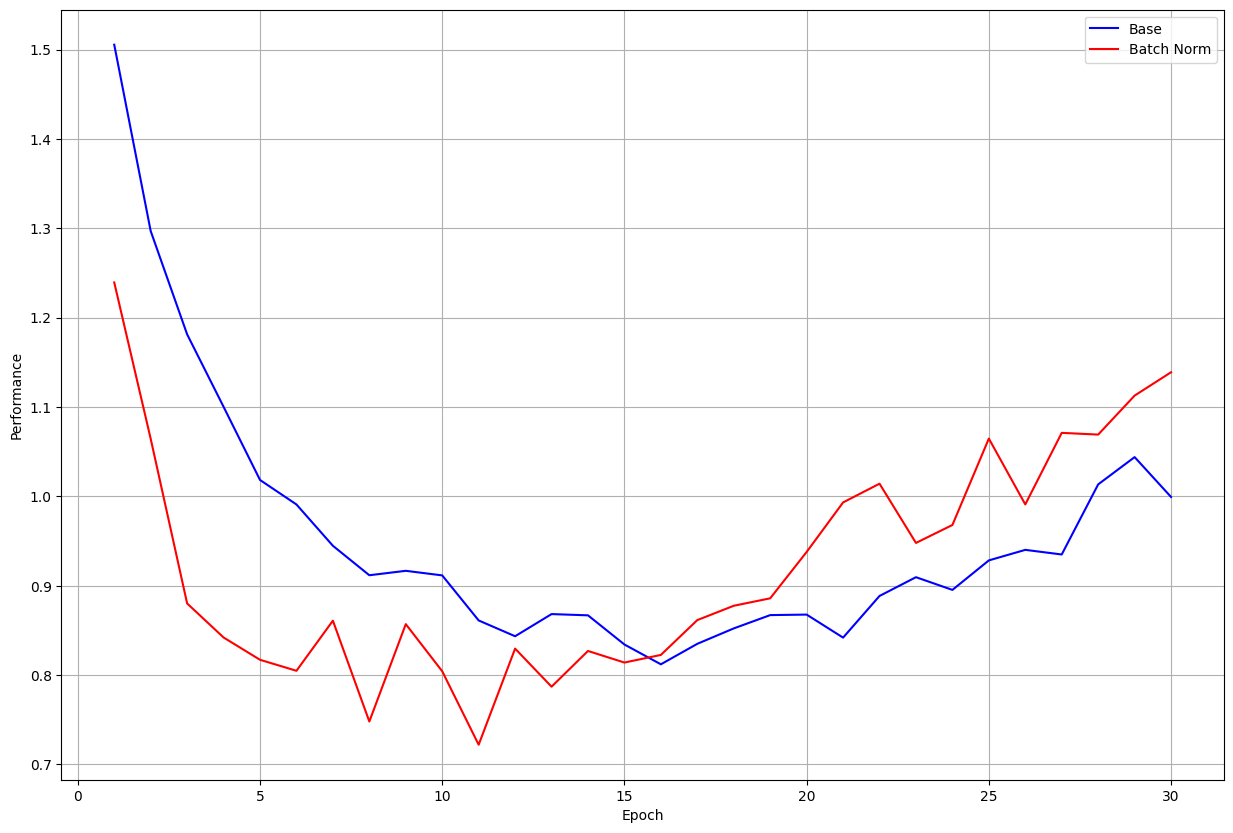

In [77]:
# Task 3 Convergence Graph

x_vals = list(range(1, epoch_num + 1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, validation_loss_values_basic, color='b', label='Base')
plt.plot(x_vals, validation_loss_values_bn, color='r', label='Batch Norm')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.show()

Task 4